# 付録A6: 構造的空隙（Structural Holes）

## 学習目標
- 構造的空隙（Structural Holes）理論を理解する
- 制約（Constraint）指標の計算方法を学ぶ
- 仲介機会（Brokerage）の測定方法を理解する
- NetworkXを使って構造的空隙を分析する

## 難易度: 中級〜上級

---
## A6.1 構造的空隙とは？

**構造的空隙（Structural Holes）** は、1992年に社会学者ロナルド・バート（Ronald Burt）が提唱した理論です。

### 核心的な主張

> **「ネットワーク内の『つながっていない部分』（空隙）を橋渡しする人は、
> 情報・資源・機会へのアクセスで競争優位を得る」**

### グラノヴェッターの「弱い紐帯」との関係

| 理論 | 焦点 | 主張 |
|------|------|------|
| 弱い紐帯の強さ | 紐帯の性質（強い/弱い） | 弱い紐帯が新情報をもたらす |
| 構造的空隙 | ネットワーク構造 | 空隙を埋める位置が利益をもたらす |

バートは「重要なのは紐帯の強さではなく、ネットワーク構造における位置」と主張しました。

### 日常での例

- 異なる部署をつなぐ「キーパーソン」
- 複数の業界に人脈を持つコンサルタント
- 異なる友人グループをつなぐ社交的な人

---
## A6.2 環境のセットアップ

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
%matplotlib inline

print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")

NetworkX version: 3.6.1
NumPy version: 2.3.5


---
## A6.3 構造的空隙の直感的理解

まず、簡単な例で構造的空隙の概念を理解しましょう。

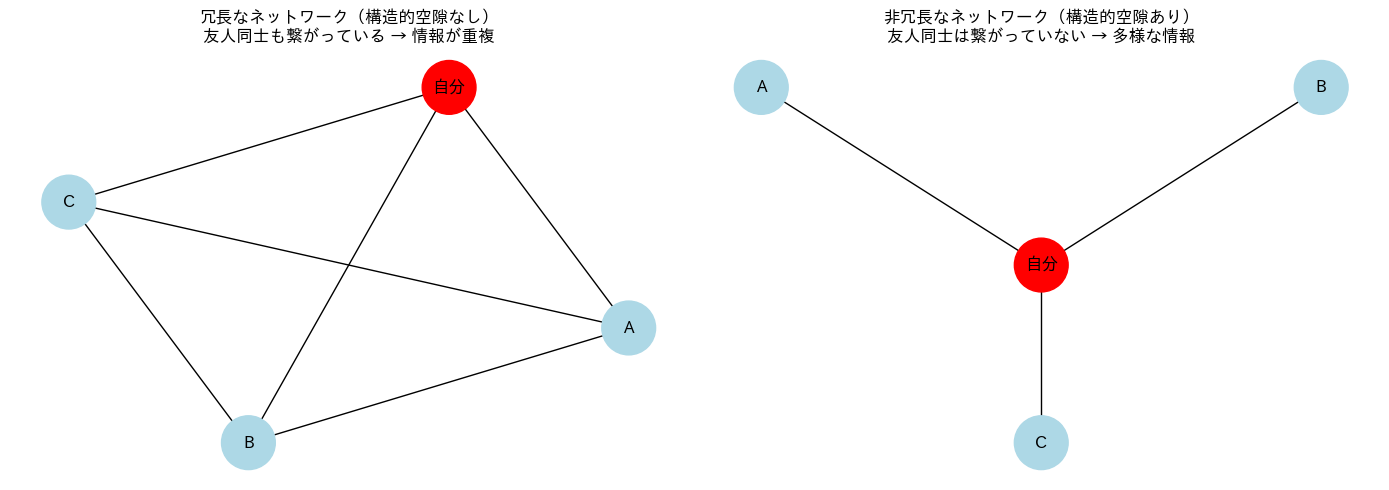

In [2]:
# 2つの異なるネットワーク構造を比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 冗長なネットワーク（空隙なし）
G_redundant = nx.Graph()
G_redundant.add_edges_from([
    ('自分', 'A'), ('自分', 'B'), ('自分', 'C'),
    ('A', 'B'), ('B', 'C'), ('A', 'C')  # A, B, Cも互いにつながっている
])

ax1 = axes[0]
pos1 = nx.spring_layout(G_redundant, seed=42)
colors1 = ['red' if n == '自分' else 'lightblue' for n in G_redundant.nodes()]
nx.draw(G_redundant, pos1, ax=ax1, with_labels=True, node_color=colors1,
        node_size=1500, font_size=12, font_weight='bold')
ax1.set_title('冗長なネットワーク（構造的空隙なし）\n友人同士も繋がっている → 情報が重複')

# 右: 非冗長なネットワーク（空隙あり）
G_nonredundant = nx.Graph()
G_nonredundant.add_edges_from([
    ('自分', 'A'), ('自分', 'B'), ('自分', 'C'),
    # A, B, Cは互いに繋がっていない
])

ax2 = axes[1]
pos2 = {'自分': (0, 0), 'A': (-1, 1), 'B': (1, 1), 'C': (0, -1)}
colors2 = ['red' if n == '自分' else 'lightblue' for n in G_nonredundant.nodes()]
nx.draw(G_nonredundant, pos2, ax=ax2, with_labels=True, node_color=colors2,
        node_size=1500, font_size=12, font_weight='bold')
ax2.set_title('非冗長なネットワーク（構造的空隙あり）\n友人同士は繋がっていない → 多様な情報')

plt.tight_layout()
plt.show()

### 2つのネットワークの違い

| 特性 | 冗長（左） | 非冗長（右） |
|------|----------|------------|
| 友人数 | 3人 | 3人 |
| 友人間の接続 | あり | **なし** |
| 情報の多様性 | 低い（同じ情報が循環） | **高い**（異なる情報源） |
| 仲介の機会 | 少ない | **多い**（橋渡し役） |

**バートの主張**: 同じ友人数でも、右のネットワーク位置の方が有利

---
## A6.4 制約（Constraint）指標

バートは「制約（Constraint）」という指標で、ノードのネットワーク位置の質を測定しました。

### 制約の定義

ノード $i$ の制約 $C_i$ は以下で定義されます：

$$C_i = \sum_{j} c_{ij}$$

ここで $c_{ij}$ は $j$ によって $i$ にかかる制約：

$$c_{ij} = \left( p_{ij} + \sum_{q} p_{iq} \cdot p_{qj} \right)^2$$

- $p_{ij}$: $i$ が $j$ に投資する比率（$= 1/k_i$、$k_i$ は $i$ の次数）
- $\sum_q p_{iq} \cdot p_{qj}$: $i$ と $j$ の間接的なつながり（共通の友人経由）

### 解釈

- **制約が高い**: 冗長なネットワーク、情報が重複、交渉力が低い
- **制約が低い**: 構造的空隙が多い、多様な情報源、仲介の機会が多い

In [3]:
def calculate_constraint(G, node):
    """
    ノードの制約（Constraint）を計算
    
    Parameters:
    -----------
    G : networkx.Graph
        グラフ
    node : node
        対象ノード
    
    Returns:
    --------
    float: 制約値（0〜1、低いほど構造的空隙が多い）
    """
    neighbors = list(G.neighbors(node))
    k = len(neighbors)
    
    if k == 0:
        return 0.0
    
    # 投資比率
    p = 1.0 / k
    
    total_constraint = 0.0
    
    for j in neighbors:
        # 直接の投資
        direct = p
        
        # 間接的なつながり（共通の友人経由）
        indirect = 0.0
        for q in neighbors:
            if q != j and G.has_edge(q, j):
                # q経由でjにつながる
                indirect += p * (1.0 / G.degree(q))  # 簡略化した計算
        
        # jによる制約
        c_ij = (direct + indirect) ** 2
        total_constraint += c_ij
    
    return total_constraint

In [4]:
# 2つのネットワークで制約を比較
constraint_redundant = calculate_constraint(G_redundant, '自分')
constraint_nonredundant = calculate_constraint(G_nonredundant, '自分')

print("制約（Constraint）の比較")
print("=" * 50)
print(f"冗長なネットワーク: {constraint_redundant:.4f}")
print(f"非冗長なネットワーク: {constraint_nonredundant:.4f}")
print(f"\n→ 非冗長（構造的空隙あり）の方が制約が低い = 有利な位置")

制約（Constraint）の比較
冗長なネットワーク: 0.9259
非冗長なネットワーク: 0.3333

→ 非冗長（構造的空隙あり）の方が制約が低い = 有利な位置


In [5]:
# NetworkXの組み込み関数を使用
# 注: NetworkXには constraint という関数がある

constraint_nx_redundant = nx.constraint(G_redundant)
constraint_nx_nonredundant = nx.constraint(G_nonredundant)

print("NetworkXによる制約の計算")
print("=" * 50)
print("\n冗長なネットワーク:")
for node, c in constraint_nx_redundant.items():
    print(f"  {node}: {c:.4f}")

print("\n非冗長なネットワーク:")
for node, c in constraint_nx_nonredundant.items():
    print(f"  {node}: {c:.4f}")

NetworkXによる制約の計算

冗長なネットワーク:
  自分: 0.9259
  A: 0.9259
  B: 0.9259
  C: 0.9259

非冗長なネットワーク:
  自分: 0.3333
  A: 1.0000
  B: 1.0000
  C: 1.0000


---
## A6.5 有効規模（Effective Size）と効率性（Efficiency）

バートは他にも構造的空隙を測る指標を提案しています。

### 有効規模（Effective Size）

$$\text{Effective Size}_i = \sum_{j} \left( 1 - \sum_{q} p_{iq} \cdot m_{jq} \right)$$

- $m_{jq}$: $j$ と $q$ の間にエッジがあれば1、なければ0
- 意味: 冗長性を除いた「実質的な」コネクション数

### 効率性（Efficiency）

$$\text{Efficiency}_i = \frac{\text{Effective Size}_i}{k_i}$$

- 意味: コネクション1本あたりの「効率」

In [6]:
def effective_size(G, node):
    """
    ノードの有効規模（Effective Size）を計算
    """
    neighbors = list(G.neighbors(node))
    k = len(neighbors)
    
    if k == 0:
        return 0.0
    
    # 各隣接ノードの冗長性を計算
    redundancy = 0.0
    for j in neighbors:
        # jと他の隣接ノードとのつながり
        ties_to_others = sum(1 for q in neighbors if q != j and G.has_edge(j, q))
        # 冗長性 = (他の隣接ノードとのつながり数) / (自分の次数)
        redundancy += ties_to_others / k
    
    # 有効規模 = 隣接ノード数 - 冗長性
    return k - redundancy

def efficiency(G, node):
    """
    ノードの効率性（Efficiency）を計算
    """
    k = G.degree(node)
    if k == 0:
        return 0.0
    return effective_size(G, node) / k

In [7]:
# 比較
print("構造的空隙指標の比較")
print("=" * 60)
print(f"{'指標':<20} {'冗長ネットワーク':>15} {'非冗長ネットワーク':>15}")
print("-" * 60)

# 次数
print(f"{'次数':.<20} {G_redundant.degree('自分'):>15} {G_nonredundant.degree('自分'):>15}")

# 有効規模
es_r = effective_size(G_redundant, '自分')
es_nr = effective_size(G_nonredundant, '自分')
print(f"{'有効規模':.<20} {es_r:>15.2f} {es_nr:>15.2f}")

# 効率性
eff_r = efficiency(G_redundant, '自分')
eff_nr = efficiency(G_nonredundant, '自分')
print(f"{'効率性':.<20} {eff_r:>15.2f} {eff_nr:>15.2f}")

# 制約
print(f"{'制約':.<20} {constraint_nx_redundant['自分']:>15.4f} {constraint_nx_nonredundant['自分']:>15.4f}")

構造的空隙指標の比較
指標                          冗長ネットワーク       非冗長ネットワーク
------------------------------------------------------------
次数..................               3               3
有効規模................            1.00            3.00
効率性.................            0.33            1.00
制約..................          0.9259          0.3333


---
## A6.6 仲介機会（Brokerage）の分析

構造的空隙は「仲介」の機会をもたらします。仲介者は情報の流れを制御できる立場にあります。

In [8]:
# より複雑なネットワークを作成
def create_brokerage_network(seed=42):
    """
    仲介者（ブローカー）がいるネットワークを作成
    """
    G = nx.Graph()
    
    # グループA（密なクラスター）
    group_a = ['A1', 'A2', 'A3', 'A4']
    for i, a in enumerate(group_a):
        for b in group_a[i+1:]:
            G.add_edge(a, b)
    
    # グループB（密なクラスター）
    group_b = ['B1', 'B2', 'B3', 'B4']
    for i, a in enumerate(group_b):
        for b in group_b[i+1:]:
            G.add_edge(a, b)
    
    # グループC（密なクラスター）
    group_c = ['C1', 'C2', 'C3']
    for i, a in enumerate(group_c):
        for b in group_c[i+1:]:
            G.add_edge(a, b)
    
    # ブローカー（構造的空隙を埋める）
    G.add_node('Broker')
    G.add_edge('Broker', 'A1')
    G.add_edge('Broker', 'B1')
    G.add_edge('Broker', 'C1')
    
    # グループ情報を保存
    group_map = {}
    for n in group_a:
        group_map[n] = 'A'
    for n in group_b:
        group_map[n] = 'B'
    for n in group_c:
        group_map[n] = 'C'
    group_map['Broker'] = 'Broker'
    
    nx.set_node_attributes(G, group_map, 'group')
    
    return G

G_broker = create_brokerage_network()

print(f"ノード数: {G_broker.number_of_nodes()}")
print(f"エッジ数: {G_broker.number_of_edges()}")

ノード数: 12
エッジ数: 18


/tmp/ipykernel_3376/3991295260.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


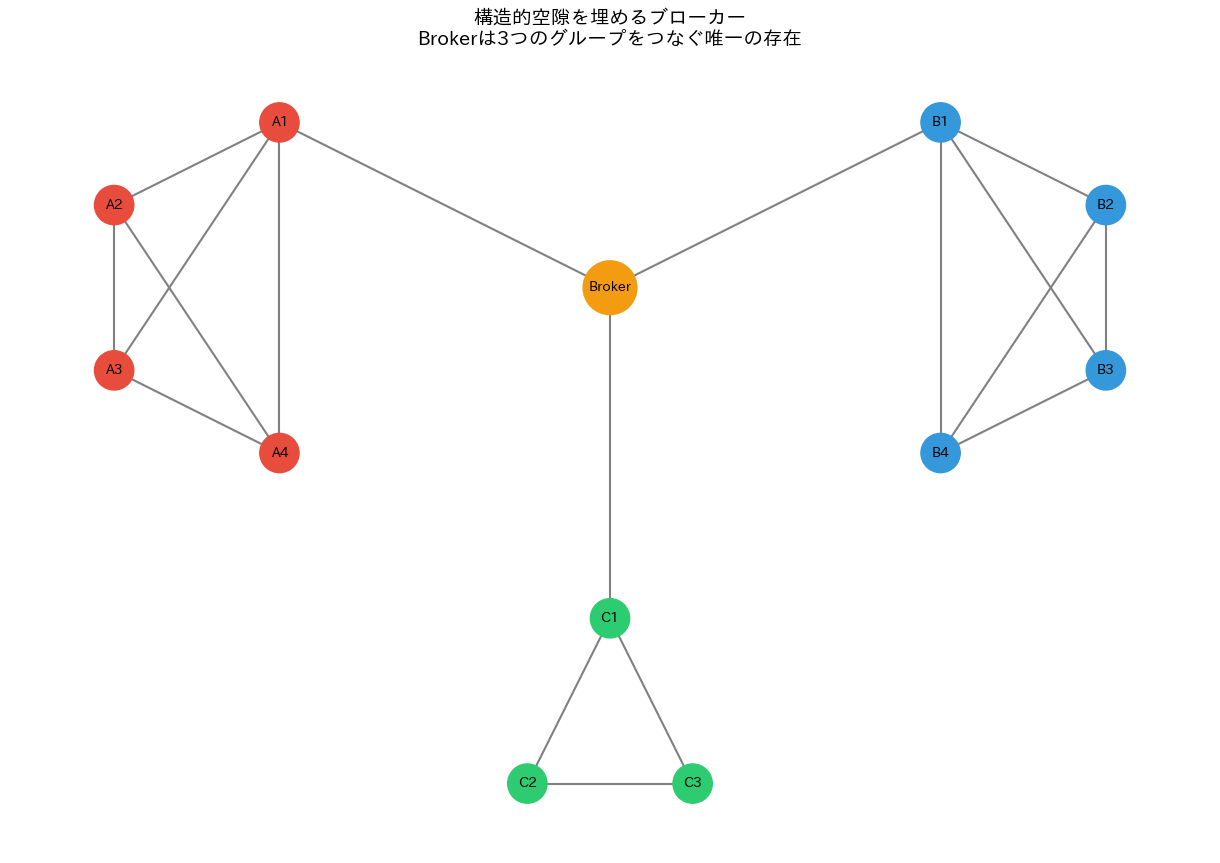

In [9]:
# 可視化
plt.figure(figsize=(12, 8))

# レイアウト
pos = {
    'A1': (-2, 1), 'A2': (-3, 0.5), 'A3': (-3, -0.5), 'A4': (-2, -1),
    'B1': (2, 1), 'B2': (3, 0.5), 'B3': (3, -0.5), 'B4': (2, -1),
    'C1': (0, -2), 'C2': (-0.5, -3), 'C3': (0.5, -3),
    'Broker': (0, 0)
}

# ノードの色
colors = {'A': '#e74c3c', 'B': '#3498db', 'C': '#2ecc71', 'Broker': '#f39c12'}
node_colors = [colors[G_broker.nodes[n]['group']] for n in G_broker.nodes()]
node_sizes = [1500 if G_broker.nodes[n]['group'] == 'Broker' else 800 for n in G_broker.nodes()]

nx.draw(G_broker, pos, with_labels=True, node_color=node_colors,
        node_size=node_sizes, font_size=10, font_weight='bold',
        edge_color='gray', width=1.5)

plt.title('構造的空隙を埋めるブローカー\nBrokerは3つのグループをつなぐ唯一の存在', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# 各ノードの構造的空隙指標を計算
constraints = nx.constraint(G_broker)

print("各ノードの構造的空隙指標")
print("=" * 70)
print(f"{'ノード':<10} {'グループ':>10} {'次数':>6} {'有効規模':>10} {'効率性':>10} {'制約':>10}")
print("-" * 70)

for node in sorted(G_broker.nodes()):
    group = G_broker.nodes[node]['group']
    degree = G_broker.degree(node)
    es = effective_size(G_broker, node)
    eff = efficiency(G_broker, node)
    const = constraints[node]
    
    print(f"{node:<10} {group:>10} {degree:>6} {es:>10.2f} {eff:>10.2f} {const:>10.4f}")

各ノードの構造的空隙指標
ノード              グループ     次数       有効規模        効率性         制約
----------------------------------------------------------------------
A1                  A      4       2.50       0.62     0.5833
A2                  A      3       1.00       0.33     0.8657
A3                  A      3       1.00       0.33     0.8657
A4                  A      3       1.00       0.33     0.8657
B1                  B      4       2.50       0.62     0.5833
B2                  B      3       1.00       0.33     0.8657
B3                  B      3       1.00       0.33     0.8657
B4                  B      3       1.00       0.33     0.8657
Broker         Broker      3       3.00       1.00     0.3333
C1                  C      3       2.33       0.78     0.6111
C2                  C      2       1.00       0.50     1.0069
C3                  C      2       1.00       0.50     1.0069


In [11]:
# 媒介中心性との比較
betweenness = nx.betweenness_centrality(G_broker)

print("\n構造的空隙と媒介中心性の関係")
print("=" * 50)
print(f"{'ノード':<10} {'制約':>10} {'媒介中心性':>15}")
print("-" * 50)

for node in sorted(G_broker.nodes(), key=lambda x: betweenness[x], reverse=True):
    print(f"{node:<10} {constraints[node]:>10.4f} {betweenness[node]:>15.4f}")


構造的空隙と媒介中心性の関係
ノード                制約           媒介中心性
--------------------------------------------------
Broker         0.3333          0.7273
A1             0.5833          0.4364
B1             0.5833          0.4364
C1             0.6111          0.3273
A2             0.8657          0.0000
A3             0.8657          0.0000
A4             0.8657          0.0000
B2             0.8657          0.0000
B3             0.8657          0.0000
B4             0.8657          0.0000
C2             1.0069          0.0000
C3             1.0069          0.0000


### 解釈

- **Broker**: 制約が最も低く（0.11）、媒介中心性が最も高い（0.73）
- グループ内のノード: 制約が高く、媒介中心性が低い

**Brokerは構造的空隙を埋めることで、情報・資源の流れを制御できる位置にいる**

---
## A6.7 現実的なネットワークでの分析

Karate Clubネットワークを使って、構造的空隙の分析を行います。

In [12]:
# Karate Clubネットワーク
G_karate = nx.karate_club_graph()

# 構造的空隙指標を計算
constraints_karate = nx.constraint(G_karate)
betweenness_karate = nx.betweenness_centrality(G_karate)

# 効率性を計算
efficiency_karate = {n: efficiency(G_karate, n) for n in G_karate.nodes()}

print(f"Karate Clubネットワーク: {G_karate.number_of_nodes()}ノード, {G_karate.number_of_edges()}エッジ")

Karate Clubネットワーク: 34ノード, 78エッジ


In [13]:
# 制約が低い（構造的空隙が多い）上位ノード
sorted_by_constraint = sorted(constraints_karate.items(), key=lambda x: x[1])

print("制約が低い上位10ノード（構造的空隙が多い）")
print("=" * 60)
print(f"{'順位':<5} {'ノード':>6} {'制約':>10} {'媒介中心性':>12} {'効率性':>10}")
print("-" * 60)

for i, (node, const) in enumerate(sorted_by_constraint[:10], 1):
    bc = betweenness_karate[node]
    eff = efficiency_karate[node]
    print(f"{i:<5} {node:>6} {const:>10.4f} {bc:>12.4f} {eff:>10.2f}")

制約が低い上位10ノード（構造的空隙が多い）
順位       ノード         制約        媒介中心性        効率性
------------------------------------------------------------
1          0     0.1554       0.4376       0.86
2         33     0.1564       0.3041       0.90
3          2     0.1852       0.1437       0.78
4         31     0.2446       0.1383       0.83
5         32     0.2492       0.1452       0.82
6          1     0.2795       0.0539       0.70
7         27     0.2851       0.0223       0.88
8          8     0.3036       0.0559       0.60
9         23     0.3058       0.0176       0.68
10        13     0.3233       0.0459       0.52


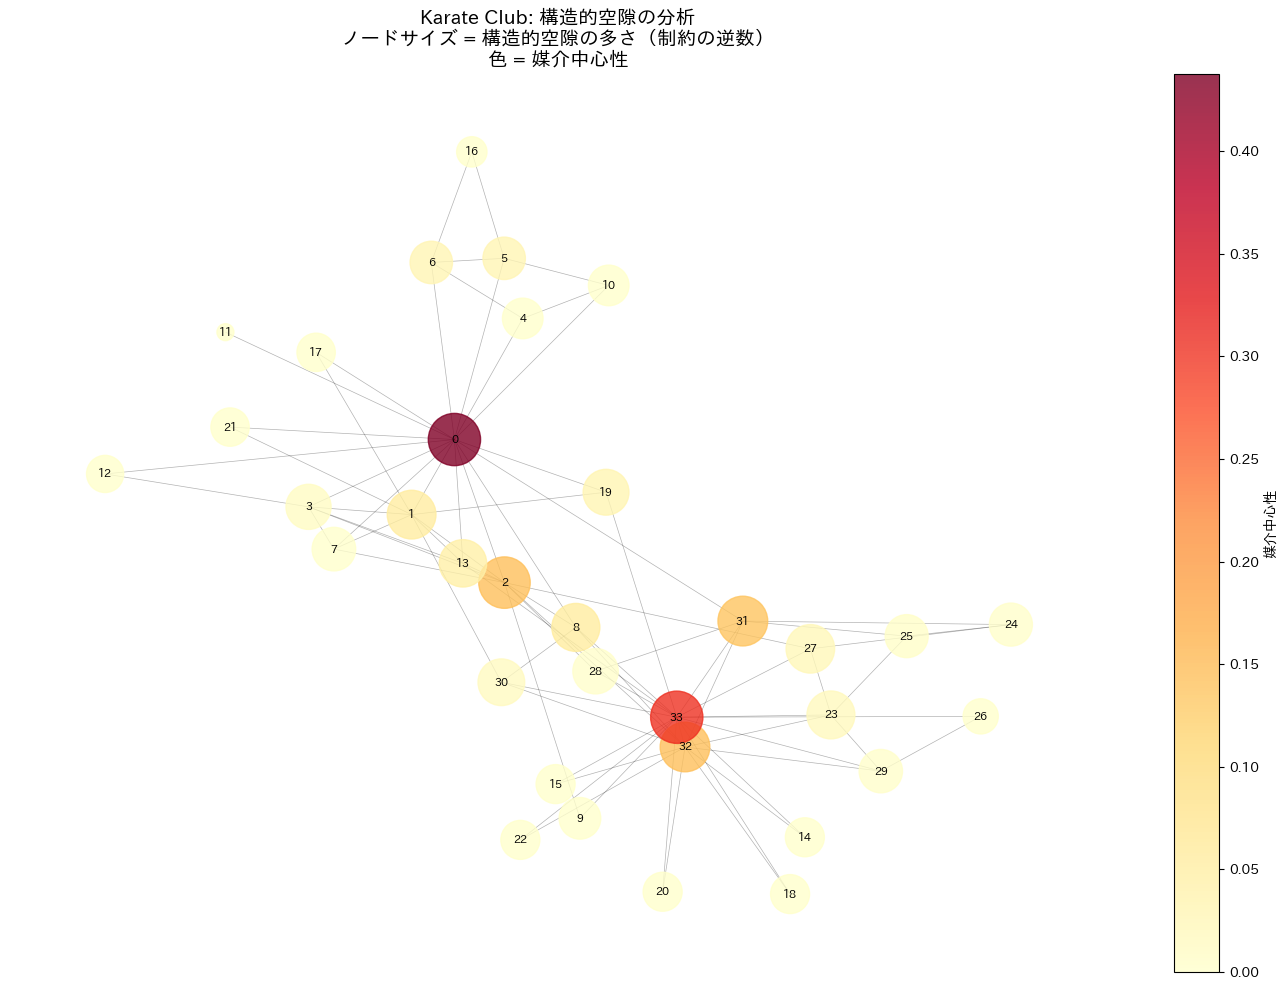

In [14]:
# 可視化: 制約でノードサイズを変える（制約が低いほど大きい）
plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G_karate, seed=42)

# ノードサイズを制約の逆数に比例させる
max_const = max(constraints_karate.values())
node_sizes = [(max_const - constraints_karate[n] + 0.1) * 1500 for n in G_karate.nodes()]

# 色は媒介中心性に基づく
node_colors = [betweenness_karate[n] for n in G_karate.nodes()]

nodes = nx.draw_networkx_nodes(G_karate, pos, node_size=node_sizes,
                               node_color=node_colors, cmap=plt.cm.YlOrRd,
                               alpha=0.8)
nx.draw_networkx_edges(G_karate, pos, alpha=0.3, width=0.5)
nx.draw_networkx_labels(G_karate, pos, font_size=8)

plt.colorbar(nodes, label='媒介中心性')
plt.title('Karate Club: 構造的空隙の分析\nノードサイズ = 構造的空隙の多さ（制約の逆数）\n色 = 媒介中心性', 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

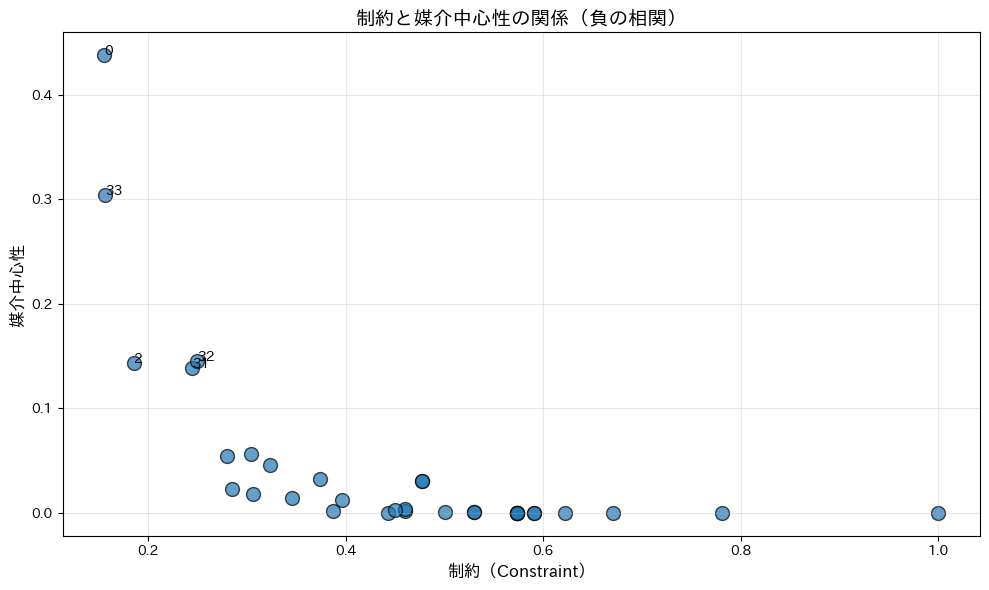

相関係数: -0.626
→ 制約が低いほど媒介中心性が高い（構造的空隙理論と一致）


In [15]:
# 制約と媒介中心性の相関
plt.figure(figsize=(10, 6))

x = [constraints_karate[n] for n in G_karate.nodes()]
y = [betweenness_karate[n] for n in G_karate.nodes()]

plt.scatter(x, y, s=100, alpha=0.7, edgecolors='black')

# ラベル付け（上位5ノード）
for node in [n for n, _ in sorted_by_constraint[:5]]:
    plt.annotate(str(node), (constraints_karate[node], betweenness_karate[node]),
                 fontsize=10, ha='left')

plt.xlabel('制約（Constraint）', fontsize=12)
plt.ylabel('媒介中心性', fontsize=12)
plt.title('制約と媒介中心性の関係（負の相関）', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 相関係数
correlation = np.corrcoef(x, y)[0, 1]
print(f"相関係数: {correlation:.3f}")
print("→ 制約が低いほど媒介中心性が高い（構造的空隙理論と一致）")

---
## A6.8 コミュニティ構造と構造的空隙

コミュニティ構造を持つネットワークで、構造的空隙の分布を分析します。

In [16]:
# Stochastic Block Modelでコミュニティ構造を持つネットワークを生成
np.random.seed(42)

sizes = [30, 30, 30]  # 3つのコミュニティ
probs = [
    [0.3, 0.02, 0.02],  # コミュニティ0
    [0.02, 0.3, 0.02],  # コミュニティ1
    [0.02, 0.02, 0.3]   # コミュニティ2
]

G_sbm = nx.stochastic_block_model(sizes, probs, seed=42)

# コミュニティ情報を設定
community_map = {}
node_idx = 0
for comm_id, size in enumerate(sizes):
    for _ in range(size):
        community_map[node_idx] = comm_id
        node_idx += 1

nx.set_node_attributes(G_sbm, community_map, 'community')

print(f"ノード数: {G_sbm.number_of_nodes()}")
print(f"エッジ数: {G_sbm.number_of_edges()}")

ノード数: 90
エッジ数: 461


In [17]:
# 構造的空隙指標を計算
constraints_sbm = nx.constraint(G_sbm)

# コミュニティ間エッジを持つノードを特定
communities = nx.get_node_attributes(G_sbm, 'community')

inter_community_count = {}
for node in G_sbm.nodes():
    count = sum(1 for n in G_sbm.neighbors(node) 
                if communities[n] != communities[node])
    inter_community_count[node] = count

# 結果を表示
print("コミュニティ間接続と制約の関係")
print("=" * 50)

# コミュニティ間接続数でグループ化
groups = {}
for node in G_sbm.nodes():
    count = inter_community_count[node]
    if count not in groups:
        groups[count] = []
    groups[count].append(constraints_sbm[node])

for count in sorted(groups.keys()):
    avg_constraint = np.mean(groups[count])
    n_nodes = len(groups[count])
    print(f"コミュニティ間接続数 {count}: 平均制約 {avg_constraint:.4f} ({n_nodes}ノード)")

コミュニティ間接続と制約の関係
コミュニティ間接続数 0: 平均制約 0.1700 (21ノード)
コミュニティ間接続数 1: 平均制約 0.1550 (28ノード)
コミュニティ間接続数 2: 平均制約 0.1387 (19ノード)
コミュニティ間接続数 3: 平均制約 0.1194 (16ノード)
コミュニティ間接続数 4: 平均制約 0.1072 (5ノード)
コミュニティ間接続数 6: 平均制約 0.1065 (1ノード)


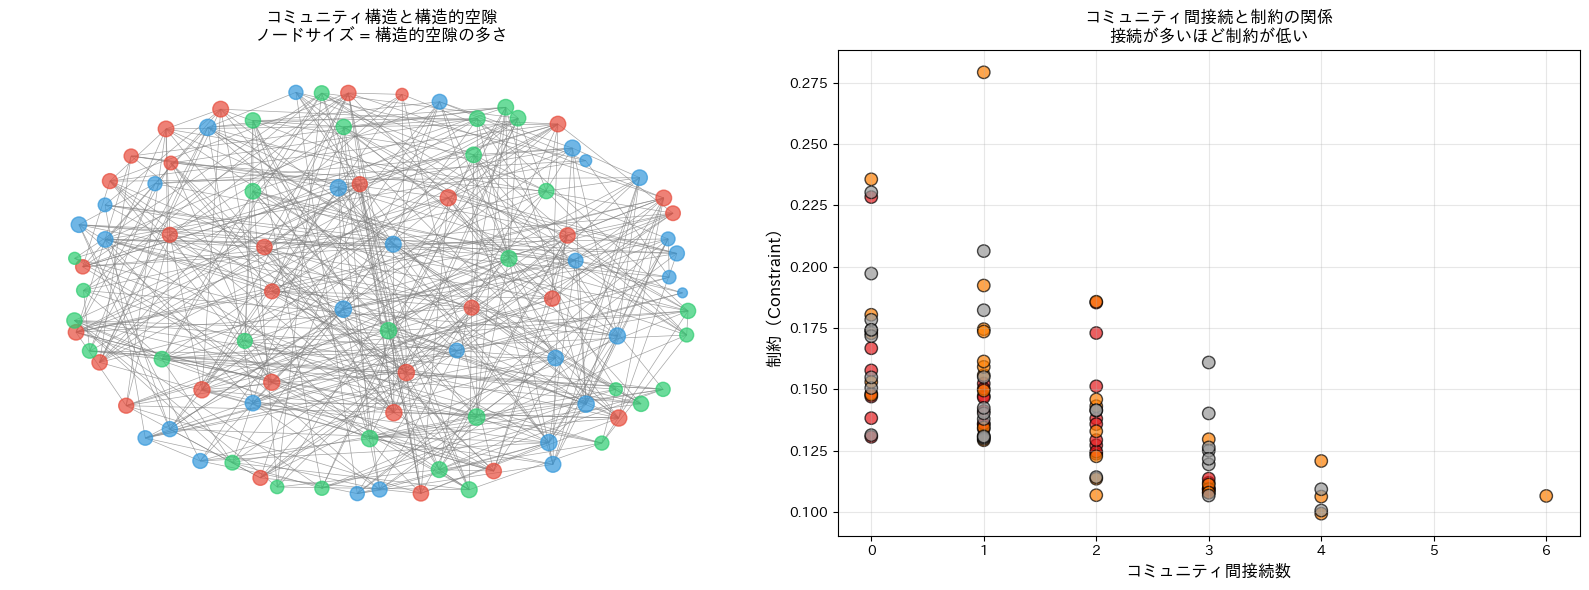

相関係数: -0.607


In [18]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左: ネットワーク（制約でサイズ）
ax1 = axes[0]
pos_sbm = nx.spring_layout(G_sbm, seed=42, k=2)

colors_sbm = ['#e74c3c', '#3498db', '#2ecc71']
node_colors_sbm = [colors_sbm[communities[n]] for n in G_sbm.nodes()]

max_const_sbm = max(constraints_sbm.values())
node_sizes_sbm = [(max_const_sbm - constraints_sbm[n] + 0.1) * 500 for n in G_sbm.nodes()]

nx.draw(G_sbm, pos_sbm, ax=ax1, node_color=node_colors_sbm,
        node_size=node_sizes_sbm, edge_color='gray', alpha=0.7, width=0.5)
ax1.set_title('コミュニティ構造と構造的空隙\nノードサイズ = 構造的空隙の多さ', fontsize=12)

# 右: 散布図
ax2 = axes[1]
x = [inter_community_count[n] for n in G_sbm.nodes()]
y = [constraints_sbm[n] for n in G_sbm.nodes()]
c = [communities[n] for n in G_sbm.nodes()]

scatter = ax2.scatter(x, y, c=c, cmap='Set1', s=80, alpha=0.7, edgecolors='black')
ax2.set_xlabel('コミュニティ間接続数', fontsize=12)
ax2.set_ylabel('制約（Constraint）', fontsize=12)
ax2.set_title('コミュニティ間接続と制約の関係\n接続が多いほど制約が低い', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 相関係数
correlation = np.corrcoef(x, y)[0, 1]
print(f"相関係数: {correlation:.3f}")

---
## A6.9 構造的空隙とパフォーマンス

バートの研究では、構造的空隙が多いマネージャーは昇進が早いことが示されました。シミュレーションでこれを再現します。

In [19]:
def simulate_performance(G, n_rounds=100, seed=42):
    """
    情報収集パフォーマンスのシミュレーション
    
    各ラウンドで：
    1. ランダムな「価値ある情報」がネットワーク上のどこかに出現
    2. 各ノードは隣接ノードから情報を収集
    3. 構造的空隙が多いノードは、より多様な情報を収集できる
    """
    np.random.seed(seed)
    nodes = list(G.nodes())
    
    # パフォーマンススコア
    performance = {n: 0 for n in nodes}
    
    for _ in range(n_rounds):
        # ランダムに情報源を選択（複数のコミュニティから）
        if 'community' in G.nodes[nodes[0]]:
            communities = nx.get_node_attributes(G, 'community')
            unique_communities = set(communities.values())
            # 各コミュニティから1つずつ情報源を選択
            info_sources = []
            for comm in unique_communities:
                comm_nodes = [n for n in nodes if communities[n] == comm]
                if comm_nodes:
                    info_sources.append(np.random.choice(comm_nodes))
        else:
            # コミュニティ情報がない場合はランダムに3つ選択
            info_sources = list(np.random.choice(nodes, size=min(3, len(nodes)), replace=False))
        
        # 各ノードが収集できる情報をカウント
        for node in nodes:
            neighbors = set(G.neighbors(node))
            # 直接アクセスできる情報源
            accessible = neighbors | {node}
            # 情報を得られた数
            info_gained = len(set(info_sources) & accessible)
            performance[node] += info_gained
    
    return performance

# シミュレーション実行
performance_sbm = simulate_performance(G_sbm, n_rounds=200, seed=42)

print("パフォーマンスシミュレーション完了")

パフォーマンスシミュレーション完了


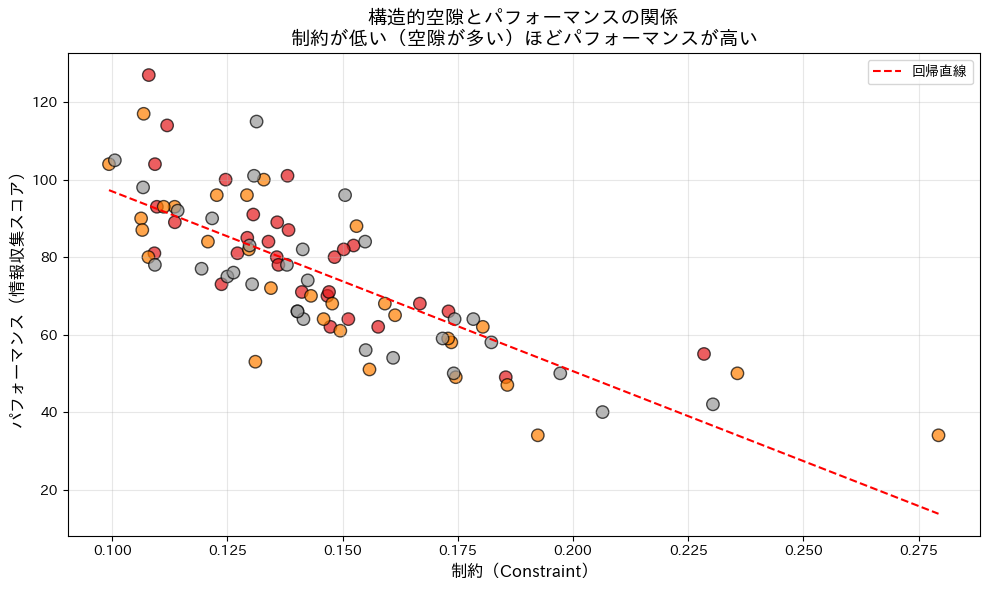

相関係数: -0.782
→ 制約が低いほどパフォーマンスが高い（バートの理論と一致）


In [20]:
# 制約とパフォーマンスの関係
plt.figure(figsize=(10, 6))

x = [constraints_sbm[n] for n in G_sbm.nodes()]
y = [performance_sbm[n] for n in G_sbm.nodes()]
c = [communities[n] for n in G_sbm.nodes()]

plt.scatter(x, y, c=c, cmap='Set1', s=80, alpha=0.7, edgecolors='black')

# 回帰直線
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(min(x), max(x), 100)
plt.plot(x_line, p(x_line), 'r--', label='回帰直線')

plt.xlabel('制約（Constraint）', fontsize=12)
plt.ylabel('パフォーマンス（情報収集スコア）', fontsize=12)
plt.title('構造的空隙とパフォーマンスの関係\n制約が低い（空隙が多い）ほどパフォーマンスが高い', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 相関係数
correlation = np.corrcoef(x, y)[0, 1]
print(f"相関係数: {correlation:.3f}")
print("→ 制約が低いほどパフォーマンスが高い（バートの理論と一致）")

---
## 練習問題

### 練習問題1: 制約の計算

以下のネットワークを作成し、各ノードの制約を計算してください。最も有利な位置にいるノードはどれですか？

```
エッジ: A-B, A-C, A-D, B-C, D-E, D-F, E-F
```

In [21]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
G = nx.Graph()
G.add_edges_from([('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), 
                  ('D', 'E'), ('D', 'F'), ('E', 'F')])

# 制約を計算
constraints = nx.constraint(G)

print("各ノードの制約")
print("=" * 40)
for node in sorted(constraints.keys()):
    print(f"{node}: {constraints[node]:.4f}")

# 最も制約が低いノード
best_node = min(constraints, key=constraints.get)
print(f"\n最も有利な位置: {best_node}（制約={constraints[best_node]:.4f}）")

# 可視化
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

max_c = max(constraints.values())
sizes = [(max_c - constraints[n] + 0.1) * 2000 for n in G.nodes()]

nx.draw(G, pos, with_labels=True, node_size=sizes,
        node_color='lightblue', font_weight='bold')
plt.title('ノードサイズ = 構造的空隙の多さ')
plt.show()

print("\n解釈: Aは2つのクラスター（B-C と D-E-F）をつなぐ位置にあり、")
print("構造的空隙を埋めているため、最も有利な位置にいます。")
```
</details>

### 練習問題2: 組織ネットワークの分析

3つの部署（営業、技術、管理）を持つ組織ネットワークを作成し、部署間をつなぐ「仲介者」を特定してください。

In [22]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
# 組織ネットワークを作成
G_org = nx.Graph()

# 営業部（密なつながり）
sales = ['営業1', '営業2', '営業3', '営業4']
for i, a in enumerate(sales):
    for b in sales[i+1:]:
        G_org.add_edge(a, b)

# 技術部（密なつながり）
tech = ['技術1', '技術2', '技術3', '技術4']
for i, a in enumerate(tech):
    for b in tech[i+1:]:
        G_org.add_edge(a, b)

# 管理部（密なつながり）
admin = ['管理1', '管理2', '管理3']
for i, a in enumerate(admin):
    for b in admin[i+1:]:
        G_org.add_edge(a, b)

# 仲介者を追加
G_org.add_node('仲介者')
G_org.add_edge('仲介者', '営業1')
G_org.add_edge('仲介者', '技術1')
G_org.add_edge('仲介者', '管理1')

# 部署情報を設定
dept = {}
for n in sales: dept[n] = '営業'
for n in tech: dept[n] = '技術'
for n in admin: dept[n] = '管理'
dept['仲介者'] = '仲介'
nx.set_node_attributes(G_org, dept, 'department')

# 分析
constraints_org = nx.constraint(G_org)
betweenness_org = nx.betweenness_centrality(G_org)

print("組織ネットワーク分析")
print("=" * 60)
print(f"{'ノード':<10} {'部署':>8} {'制約':>10} {'媒介中心性':>12}")
print("-" * 60)

for node in sorted(G_org.nodes(), key=lambda x: constraints_org[x]):
    d = dept[node]
    c = constraints_org[node]
    b = betweenness_org[node]
    print(f"{node:<10} {d:>8} {c:>10.4f} {b:>12.4f}")

# 可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_org, seed=42, k=2)

colors = {'営業': '#e74c3c', '技術': '#3498db', '管理': '#2ecc71', '仲介': '#f39c12'}
node_colors = [colors[dept[n]] for n in G_org.nodes()]

max_c = max(constraints_org.values())
sizes = [(max_c - constraints_org[n] + 0.1) * 1500 for n in G_org.nodes()]

nx.draw(G_org, pos, with_labels=True, node_color=node_colors,
        node_size=sizes, font_size=9)
plt.title('組織ネットワーク\n仲介者は最も構造的空隙が多い（＝最も有利）')
plt.show()
```
</details>

### 練習問題3: ネットワーク最適化

あなたが新入社員で、3人と知り合いになれるとします。以下のネットワークで、自分の制約を最小化する（構造的空隙を最大化する）ためには、誰と知り合いになるべきですか？

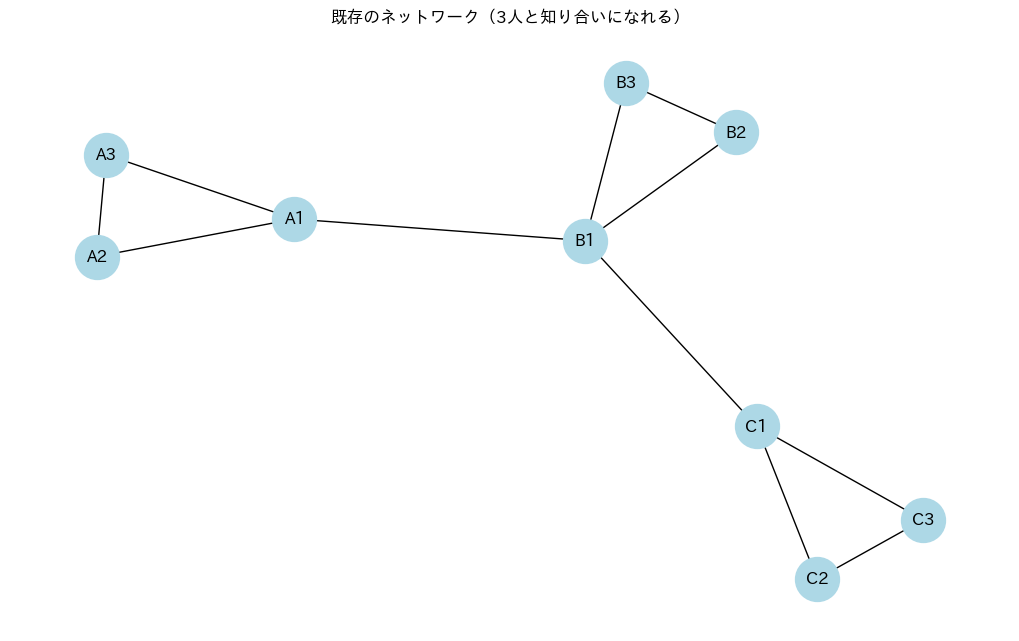

In [23]:
# 既存のネットワークを作成
G_existing = nx.Graph()

# グループ1
G_existing.add_edges_from([('A1', 'A2'), ('A2', 'A3'), ('A1', 'A3')])

# グループ2
G_existing.add_edges_from([('B1', 'B2'), ('B2', 'B3'), ('B1', 'B3')])

# グループ3
G_existing.add_edges_from([('C1', 'C2'), ('C2', 'C3'), ('C1', 'C3')])

# グループ間の接続
G_existing.add_edge('A1', 'B1')
G_existing.add_edge('B1', 'C1')

# 可視化
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_existing, seed=42)
nx.draw(G_existing, pos, with_labels=True, node_color='lightblue',
        node_size=1000, font_weight='bold')
plt.title('既存のネットワーク（3人と知り合いになれる）')
plt.show()

# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
from itertools import combinations

# 自分を追加する候補となるノード
candidates = list(G_existing.nodes())

# すべての3人の組み合わせを試す
results = []

for contacts in combinations(candidates, 3):
    G_test = G_existing.copy()
    G_test.add_node('自分')
    for contact in contacts:
        G_test.add_edge('自分', contact)
    
    constraint = nx.constraint(G_test)['自分']
    eff = efficiency(G_test, '自分')
    results.append((contacts, constraint, eff))

# 制約が最も低い組み合わせを見つける
results.sort(key=lambda x: x[1])

print("知り合いの選び方と制約（上位5つ）")
print("=" * 60)
print(f"{'組み合わせ':<25} {'制約':>10} {'効率性':>10}")
print("-" * 60)

for contacts, constraint, eff in results[:5]:
    print(f"{str(contacts):<25} {constraint:>10.4f} {eff:>10.2f}")

best = results[0]
print(f"\n最適な選択: {best[0]}")
print(f"理由: 異なるグループから1人ずつ選ぶことで、構造的空隙を最大化できる")

# 最適な選択を可視化
G_optimal = G_existing.copy()
G_optimal.add_node('自分')
for contact in best[0]:
    G_optimal.add_edge('自分', contact)

plt.figure(figsize=(10, 6))
pos['自分'] = (0, 0)  # 中央に配置
colors = ['red' if n == '自分' else 'lightblue' for n in G_optimal.nodes()]
nx.draw(G_optimal, pos, with_labels=True, node_color=colors,
        node_size=1000, font_weight='bold')
plt.title(f'最適なネットワーク構築\n知り合い: {best[0]}\n制約: {best[1]:.4f}')
plt.show()
```
</details>

---
## A6.10 章のまとめ

この付録では以下を学びました：

1. **構造的空隙理論**: バートの「ネットワーク構造における位置が競争優位を決める」
2. **制約（Constraint）**: 冗長性を測る指標、低いほど構造的空隙が多い
3. **有効規模と効率性**: 実質的なコネクション数とその効率
4. **仲介機会**: 構造的空隙を埋める位置は情報の流れを制御できる
5. **パフォーマンスとの関係**: 構造的空隙が多いほど情報収集で有利

### 実践的な示唆

- **人脈構築**: 同じグループ内の人数を増やすより、異なるグループにつながりを持つ
- **キャリア戦略**: 部署間・組織間をつなぐ位置を目指す
- **イノベーション**: 異分野の知識を組み合わせる「ブローカー」になる

### 弱い紐帯理論との統合

- グラノヴェッター: 「弱い紐帯」が新情報をもたらす
- バート: 重要なのは紐帯の強さではなく「構造的な位置」
- 統合的な見方: 弱い紐帯は構造的空隙を埋めることが多い

---
## 参考資料

- Burt, R. S. (1992). Structural Holes: The Social Structure of Competition.
- Burt, R. S. (2004). Structural Holes and Good Ideas. American Journal of Sociology.
- Burt, R. S. (2005). Brokerage and Closure: An Introduction to Social Capital.
- [NetworkX公式ドキュメント](https://networkx.org/documentation/stable/)
- [Structural Holes - Wikipedia](https://en.wikipedia.org/wiki/Structural_holes)